<a href="https://colab.research.google.com/github/SanghunOh/study_machinglearning/blob/main/codes/sanghunoh/reports/Term_2_Finetuning_MPIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

from https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?force_kitty_mode=1&force_corgi_mode=1#scrollTo=Wv4afXKj6cVa

##Connect Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path_root = '/content/drive/MyDrive/datas/'

# 작업 경로 설정
import os
os.chdir(path_root)
!pwd

/content/drive/.shortcut-targets-by-id/1tHYgEz3lQF-LmtFPXRgMBDh4UN54qeAs/datas


In [3]:
# !unzip -o ./mpie_30_shuffle.zip -d ./mpie_30_shuffle

In [4]:
!ls

dataCh4_7.mat  digitimages_binary.zip  iris.zip			mpie_30_shuffle
dataCh4_7.zip  iris_shuffle.mat        matlab_iris_shuffle.mat


##Load Dataset

In [5]:
from keras.backend import reshape
path = path_root + 'mpie_30_shuffle/'

def loadDatasetFromCSV(_datafilename, _labelfilename, label_column, rgb_expand=False):
  _feature_csv = pd.read_csv(path + _datafilename, dtype=np.float32, header=None) # image features of train data
  _feature_flatten = _feature_csv.values.flatten()

  _feature_reshape = np.reshape(_feature_flatten, (_feature_csv.shape[0], 32, 32))
  if rgb_expand:
    _feature_reshape = np.repeat(_feature_reshape[..., np.newaxis], 3, -1)    
  print(_feature_reshape.shape)
  _label_csv = pd.read_csv(path + _labelfilename, dtype=np.float32, header=None) # labels of train data
  # print(f'_label_csv : {_label_csv.shape}')
  _label = _label_csv[label_column] # get label you want

  return _feature_reshape, _label

In [6]:
import pandas as pd
import numpy as np


# train
train_feature_rgb, train_label = loadDatasetFromCSV('Traindata.csv', 'Trainlabel.csv', 0, rgb_expand=True)
# test
validation_feature_rgb, validation_label = loadDatasetFromCSV('Testdata.csv', 'Testlabel.csv', 0, rgb_expand=True)

train_feature_rgb.shape, train_label.shape, validation_feature_rgb.shape, validation_label.shape

(18777, 32, 32, 3)
(5086, 32, 32, 3)


((18777, 32, 32, 3), (18777,), (5086, 32, 32, 3), (5086,))

In [7]:
# np.unique(train_label)

In [8]:
import tensorflow as tf

def preprocessDataset(features_reshape, labels, normalization=False, batch_size=64, shuffle_buffer_size=100):
  _batch_size = batch_size
  _shuffle_buffer_size = shuffle_buffer_size

  normal_value = 1
  if normalization:
    normal_value = 255
  _features = features_reshape / normal_value
  _labels = labels
  _dataset_tensors = tf.data.Dataset.from_tensor_slices((_features, _labels))

  if _shuffle_buffer_size == None:
    _dataset_tensors = _dataset_tensors.batch(_batch_size)
  else :
    _dataset_tensors = _dataset_tensors.shuffle(_shuffle_buffer_size).batch(_batch_size)

  return _dataset_tensors

In [9]:
# batch size
train_label_length = len(train_label)
print(train_label_length)
batch_size = int(train_label_length / (train_label_length/9))

train_dataset_rgb = preprocessDataset(train_feature_rgb, train_label, batch_size=batch_size)
train_dataset_rgb

18777


<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [10]:
# train_dataset_rgb?
# train_dataset_rgb.element_spec
train_dataset_rgb.element_spec

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.float32, name=None))

9 3


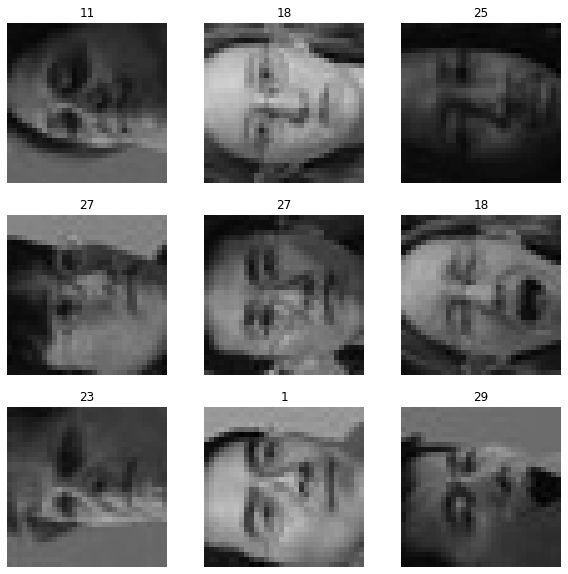

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset_rgb.take(1):
  batch_count = labels.shape[0]
  rows_cols = int(np.sqrt(batch_count))
  print(batch_count, rows_cols)
  for i in range(batch_count):
    ax = plt.subplot(rows_cols, rows_cols, i + 1)
    plt.imshow(images[i].numpy(), cmap='gray')
    plt.title(int(labels[i].numpy()))
    plt.axis("off")

## Use data augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.Resizing(height=96,width=96)
])

<class 'tuple'>, (96, 96, 3)
<class 'tuple'>, (96, 96, 3)
<class 'tuple'>, (96, 96, 3)
<class 'tuple'>, (96, 96, 3)
<class 'tuple'>, (96, 96, 3)
<class 'tuple'>, (96, 96, 3)
<class 'tuple'>, (96, 96, 3)
<class 'tuple'>, (96, 96, 3)
<class 'tuple'>, (96, 96, 3)
<class 'tuple'>, (96, 96, 3)
<class 'tuple'>, (96, 96, 3)
<class 'tuple'>, (96, 96, 3)
<class 'tuple'>, (96, 96, 3)
<class 'tuple'>, (96, 96, 3)
<class 'tuple'>, (96, 96, 3)
<class 'tuple'>, (96, 96, 3)


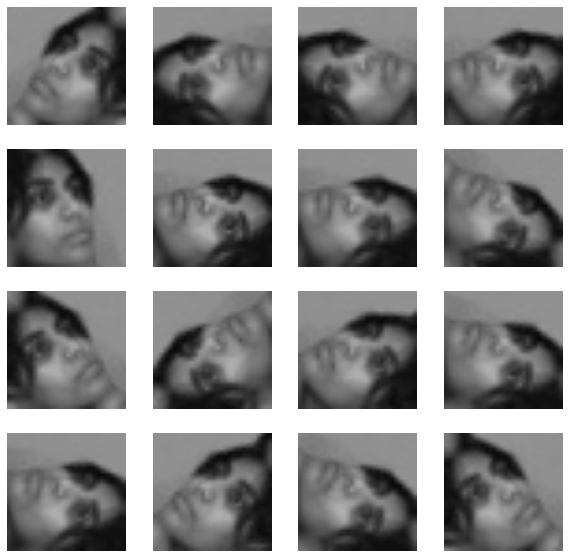

In [13]:
plt.figure(figsize=(10, 10))
for image, _ in train_dataset_rgb.take(1):
  first_image = image[0]
  batch_count = 16
  rows_cols = int(np.sqrt(batch_count))
  for i in range(batch_count):
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    print(f'{type(augmented_image[0].numpy().shape)}, {augmented_image[0].numpy().shape}')
    ax = plt.subplot(rows_cols, rows_cols, i + 1)
    plt.imshow(augmented_image[0], cmap='gray')
    plt.axis('off')

##check pre-trained model

In [14]:
# train_dataset_rgb.shape[1:]

In [15]:
class_count = len(train_label.unique())
class_count

30

In [16]:
from  tensorflow.keras import layers

trained_model = tf.keras.applications.MobileNetV2(input_shape=(96,96,3),
                                               include_top=False,
                                               weights='imagenet')
# trained_model.summary()

9420800/9406464 [==============================] - 0s 0us/step


In [17]:
trained_model.trainable = True
fine_tune_at = int((1 - 0.1) * len(trained_model.layers))
for layer in trained_model.layers[:fine_tune_at]:
  layer.trainable = False
  # print(layer.name)
len(trained_model.trainable_variables)

17

In [18]:
int((1 - 0.1) * len(trained_model.layers))

138

In [19]:
trained_model.output    # without classfication layers

<KerasTensor: shape=(None, 3, 3, 1280) dtype=float32 (created by layer 'out_relu')>

In [20]:
trained_model.trainable = False
# trained_model.summary()

##make model from pre-trained model

In [21]:
image_shape = train_feature_rgb.shape[1:]
print(image_shape)

(32, 32, 3)


In [22]:
import tensorflow as tf
from tensorflow.keras import layers

# Create the base model from the pre-trained models
def make_model(_class_cnt, _learning_rate=0.0001,_logits_flag=True, fine_tune_at=0.0
               , trained_model_name ='MobileNetV2', epochs=2, label_class=0):

  if trained_model_name == 'MobileNetV2':
    _trained_model = tf.keras.applications.MobileNetV2(input_shape=(96,96,3),
                                               include_top=False,
                                               weights='imagenet')

  inputs = layers.Input(shape=(32,32,3), name='custom_input')
  augment_input = data_augmentation(inputs)
  add_layer = _trained_model(augment_input, training=False)
  add_layer = tf.keras.layers.GlobalAveragePooling2D()(add_layer)
  add_layer = tf.keras.layers.Dropout(0.2)(add_layer)
  outputs = tf.keras.layers.Dense(_class_cnt)(add_layer)
  _model = tf.keras.Model(inputs, outputs)

  _model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=_logits_flag),
              metrics=['accuracy'])

  _trained_model.trainable = True
  fine_tune_at = int((1 - 0.1) * len(_trained_model.layers))
  for layer in _trained_model.layers[:fine_tune_at]:
    layer.trainable = False
    # print(layer.name)
  # len(trained_model.trainable_variables)
  return _model


In [23]:
model = make_model(2,fine_tune_at=0.1)
# model.summary()
len(model.trainable_variables)

19

In [24]:
validation_dataset = preprocessDataset(validation_feature_rgb, validation_label, batch_size=batch_size, shuffle_buffer_size=None)
validation_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

##callback function for fit time

In [25]:
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
TimeHistory()

## fit model

In [26]:
rows_length = train_feature_rgb.shape[0]
# steps_per_epoch = int(rows_length / (rows_length))
steps_per_epoch = int(rows_length / (rows_length/5))

def model_fit(_param, _train_dataset, _validation_dataset):
  tf.keras.backend.clear_session()

  _model = make_model(**_param)
  time_callback = TimeHistory()
  _history = _model.fit(_train_dataset, epochs=_param['epochs'], validation_data=_validation_dataset
                      , callbacks=[time_callback], steps_per_epoch=steps_per_epoch)
  _execution_time = sum(time_callback.times)
  return _model, _history, _execution_time, _param

In [27]:
label_class = 0
# train
train_feature_rgb, train_label = loadDatasetFromCSV('Traindata.csv', 'Trainlabel.csv', label_class, rgb_expand=True)
class_cnt = len(np.unique(train_label))
# test
validation_feature_rgb, validation_label = loadDatasetFromCSV('Testdata.csv', 'Testlabel.csv', label_class, rgb_expand=True)

train_dataset_rgb = preprocessDataset(train_feature_rgb, train_label)
validation_dataset = preprocessDataset(validation_feature_rgb, validation_label, shuffle_buffer_size=None)

param = {'_class_cnt':class_cnt, '_learning_rate':0.0001,'_logits_flag':True, 'fine_tune_at':0.0
         , 'trained_model_name':'MobileNetV2', 'epochs':2, 'label_class':0}

model_fit(param, train_dataset_rgb, validation_dataset)

(18777, 32, 32, 3)
(5086, 32, 32, 3)
Epoch 1/2
5/5 [==============================] - 42s 9s/step - loss: 3.5948 - accuracy: 0.0469 - val_loss: 3.4068 - val_accuracy: 0.0480
Epoch 2/2
5/5 [==============================] - 33s 8s/step - loss: 3.4065 - accuracy: 0.0437 - val_loss: 3.4127 - val_accuracy: 0.0358


(<keras.engine.functional.Functional at 0x7f15369a5f50>,
 74.25827503204346,
 {'_class_cnt': 30,
  '_learning_rate': 0.0001,
  '_logits_flag': True,
  'epochs': 2,
  'fine_tune_at': 0.0,
  'label_class': 0,
  'trained_model_name': 'MobileNetV2'})

## fit with multi params

In [28]:
param = {'_class_cnt':class_cnt, '_learning_rate':0.0001,'_logits_flag':True, 'fine_tune_at':0.0
         , 'trained_model_name':'MobileNetV2', 'epochs':2, 'label_class':0}

In [29]:
# param 6
params = list()
param_key_list = list(param.keys())
epochs_list = [10]
_learning_rate_list = [0.0001, 0.01]
_logits_flag_list = [True, False]
fine_tune_at_list = [0.0, 0.1]

for _learning_rate in _learning_rate_list:
  for _logits_flag in _logits_flag_list:
    for fine_tune_at in fine_tune_at_list:
      for epochs in epochs_list:
        param_dict = dict()
        param_dict['_learning_rate'] = _learning_rate
        param_dict['_logits_flag'] = _logits_flag
        param_dict['fine_tune_at'] = fine_tune_at
        param_dict['epochs'] = epochs
        # print(param_dict)
        params.append(param_dict)
len(params)

8

In [30]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%Y%m%d%H%M")
print("date and time =", dt_string)

import pickle

now = 2022-05-30 15:19:40.881770
date and time = 202205301519


In [31]:
# params = params[5:7]
label_classes = [1, 2, 4]
results_list = list()
for label_class in label_classes:
  train_feature_rgb, train_label = loadDatasetFromCSV('Traindata.csv', 'Trainlabel.csv', label_class, rgb_expand=True)
  class_cnt = len(np.unique(train_label))
  # test
  validation_feature_rgb, validation_label = loadDatasetFromCSV('Testdata.csv', 'Testlabel.csv', label_class, rgb_expand=True)

  train_dataset_rgb = preprocessDataset(train_feature_rgb, train_label)
  validation_dataset = preprocessDataset(validation_feature_rgb, validation_label, shuffle_buffer_size=None)

  results = list()          
  for idx, param in enumerate(params):
    param['_class_cnt'] = class_cnt
    param['label_class'] = label_class
    print('-'*5 +'[ '+ str(idx) + ' ]'+ '-'*5 + str(param))
    results.append(model_fit(param, train_dataset_rgb, validation_dataset))
  # save
  with open(f'results_Finetuning_label_{label_class}_{dt_string}.pickle', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)
  results_list = results_list + results


(18777, 32, 32, 3)
(5086, 32, 32, 3)
-----[ 0 ]-----{'_learning_rate': 0.0001, '_logits_flag': True, 'fine_tune_at': 0.0, 'epochs': 10, '_class_cnt': 6, 'label_class': 1}
Epoch 1/10
5/5 [==============================] - 39s 8s/step - loss: 1.9096 - accuracy: 0.4125 - val_loss: 1.4568 - val_accuracy: 0.5387
Epoch 2/10
5/5 [==============================] - 33s 8s/step - loss: 1.4147 - accuracy: 0.5656 - val_loss: 1.4608 - val_accuracy: 0.5387
Epoch 3/10
5/5 [==============================] - 33s 8s/step - loss: 1.4465 - accuracy: 0.5562 - val_loss: 1.4788 - val_accuracy: 0.5387
Epoch 4/10
5/5 [==============================] - 33s 8s/step - loss: 1.4485 - accuracy: 0.5625 - val_loss: 1.4661 - val_accuracy: 0.5387
Epoch 5/10
5/5 [==============================] - 32s 8s/step - loss: 1.4243 - accuracy: 0.5688 - val_loss: 1.4340 - val_accuracy: 0.5387
Epoch 6/10
5/5 [==============================] - 32s 8s/step - loss: 1.4199 - accuracy: 0.5625 - val_loss: 1.4379 - val_accuracy: 0.5387
E

In [32]:
# save
with open(f'results_Finetuning_{dt_string}.pickle', 'wb') as f:
    pickle.dump(results_list, f, pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: ram://b73ca9e0-3976-45e6-adc0-b5b445df37eb/assets
INFO:tensorflow:Assets written to: ram://06d6f51e-7aa0-47ea-992f-432cb1194cb6/assets
INFO:tensorflow:Assets written to: ram://2f6bd058-fad1-4675-8a64-0392ca746720/assets
INFO:tensorflow:Assets written to: ram://08f47f55-91b1-431d-aa67-dd2a600c7db7/assets
INFO:tensorflow:Assets written to: ram://52dff555-3253-4ab0-8a51-f98cfb56032a/assets
INFO:tensorflow:Assets written to: ram://fbd74bcb-8f00-45b6-a03e-117ea6671934/assets
INFO:tensorflow:Assets written to: ram://08649c08-9c5e-41c1-8e15-7ef9fd68bde4/assets
INFO:tensorflow:Assets written to: ram://9fe81465-8096-4a1f-a867-91d778e3d1ef/assets
INFO:tensorflow:Assets written to: ram://386548f2-c50c-4318-9a9d-21281249b66d/assets
INFO:tensorflow:Assets written to: ram://4518a70f-0181-4109-8ca2-13cb40c92ebd/assets
INFO:tensorflow:Assets written to: ram://fd1cadbc-ad9f-4e48-9c38-a34633998bc2/assets
INFO:tensorflow:Assets written to: ram://c57eb5e0-260a-40a9-9162-